<a href="https://colab.research.google.com/github/ahmedabdelwahab1/-data_science_linear./blob/main/FAW_Dr_Ahmed_Abdelwahab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import necessary libraries**

### **Fall armyworm identification  task  from other insect pests or even from other species related to the same genus**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (VGG16, ResNet50, Xception, InceptionV3)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **Data Preprocessing**

In [ ]:
# Dataset directory
data_dir = '/kaggle/input/fallarmyworm'
image_paths = []
labels = []

# Dataset class folders
class_names = ['FAW-Adult', 'FAW-Eggs', 'FAW-Larvae', 'FAW-Pupae']

# Loop through each class and collect image paths and labels
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_images = os.listdir(class_dir)
    image_paths.extend([os.path.join(class_dir, img) for img in class_images])
    labels.extend([class_name] * len(class_images))

# Create a DataFrame to store image paths and labels
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

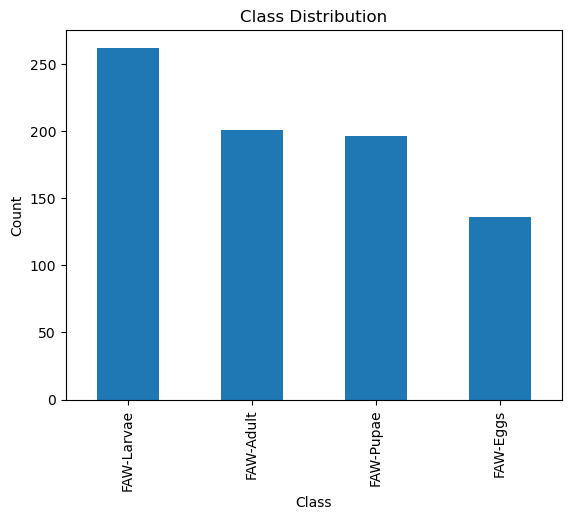

In [ ]:
# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.22, random_state=42)

# Visualize the distribution of classes in the dataset
data['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# **Data augmentation and preprocessing**

In [ ]:
# Batch size
batch_size = 16

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for validation and test images
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generate batches of data using data generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 556 validated image filenames belonging to 4 classes.
Found 156 validated image filenames belonging to 4 classes.
Found 79 validated image filenames belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


# **Function to build models for hyperparameter tuning**

In [ ]:
def build_model(hp):
    base_model = hp.Choice('base_model', ['VGG16', 'ResNet50',
                                          'Xception', 'InceptionV3'])

    if base_model == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.run_eagerly = True
    return model

In [ ]:
# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparam_tuning',
    project_name='faw_classification'
)

# Define early stopping to prevent overfitting during tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for best hyperparameters using training and validation data
tuner.search(train_generator, epochs=100,callbacks=[early_stopping], validation_data=val_generator)

Trial 5 Complete [00h 02m 07s]
val_accuracy: 0.9230769276618958

Best val_accuracy So Far: 0.9230769276618958
Total elapsed time: 00h 16m 33s


# **Get the best model and save it**


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/kaggle/working/best_model.h5')

# **Evaluate the best model on the test set**

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

5/5 [==============================] - 1s 162ms/step - loss: 0.2250 - accuracy: 0.9241
Test Loss: 0.2250
Test Accuracy: 0.9241


# **Perform inference on new images**

1/1 [==============================] - 0s 101ms/step


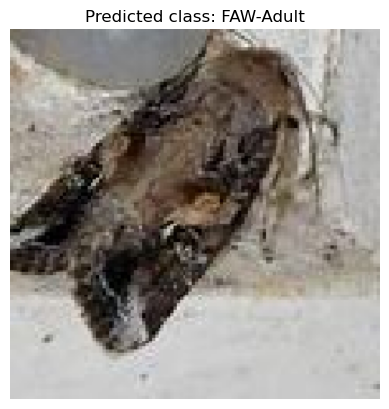

1/1 [==============================] - 0s 99ms/step


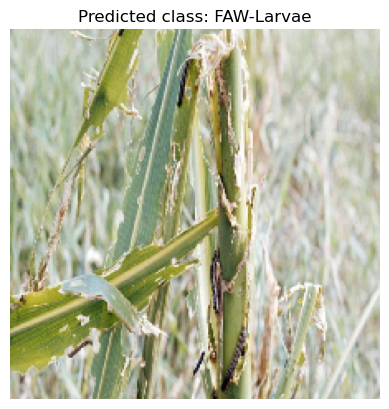

1/1 [==============================] - 0s 103ms/step


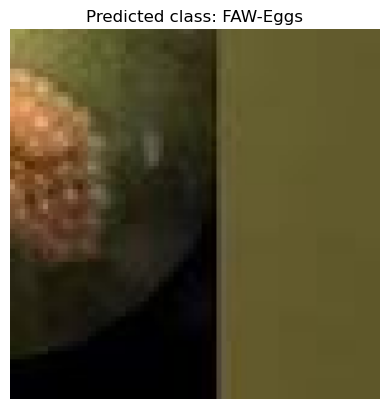

In [ ]:
new_images = [
    '/kaggle/input/fallarmyworm/FAW-Adult/7u65.jpg1.jpg',
    '/kaggle/input/fallarmyworm/FAW-Larvae/Crop20damage20from20FAW.jpg',
    '/kaggle/input/fallarmyworm/FAW-Eggs/652.jpg'
]

# Loop through new images and make predictions
for image_path in new_images:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    prediction = best_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')
    plt.show()

# **Calculate and display confusion matrix and classification report**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
true_labels = test_generator.classes

# Generate predictions in batches
predictions = []
num_batches = len(test_generator)
for _ in range(num_batches):
    batch = test_generator.next()
    batch_preds = best_model.predict(batch[0])
    predictions.extend(batch_preds)

predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


1/1 [==============================] - 0s 117ms/step
Confusion Matrix:
[[3 2 5 9]
 [1 1 5 5]
 [8 5 7 4]
 [8 3 6 7]]

Classification Report:
              precision    recall  f1-score   support

   FAW-Adult       0.15      0.16      0.15        19
    FAW-Eggs       0.09      0.08      0.09        12
  FAW-Larvae       0.30      0.29      0.30        24
   FAW-Pupae       0.28      0.29      0.29        24

    accuracy                           0.23        79
   macro avg       0.21      0.21      0.21        79
weighted avg       0.23      0.23      0.23        79



# **Load the trained model**


In [ ]:
model_path = '/kaggle/working/best_model.h5'  # Path to the saved model
loaded_model = tf.keras.models.load_model(model_path)

# **List of new image paths for inference**


In [ ]:
new_images = [
    '/kaggle/input/fallarmyworm/FAW-Adult/7u65.jpg1.jpg',
    '/kaggle/input/fallarmyworm/FAW-Larvae/Crop20damage20from20FAW.jpg',
    '/kaggle/input/fallarmyworm/FAW-Eggs/652.jpg'
]

# **Loop through new images and perform inference**
**Here we can use the suspected insect pest to make sure that would be the Fall armyworm damage or not (main target of the task)**

In [ ]:
for image_path in new_images:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make predictions using the loaded model
    prediction = loaded_model.predict(img_array)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]

    # Display the image and predicted class
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')
    plt.show()